# Octopamine Side Learning Y-maze

## Load packages

In [2]:
require(reshape2) # For data handling
require(lme4) # Linear mixed-effects models
require(emmeans) # Post-hoc analysis on the model
require(DHARMa) # Evaluate model fit
require(AICcmodavg) # For model selection and averaging

Loading required package: reshape2

Loading required package: lme4

Loading required package: Matrix

Loading required package: emmeans

Loading required package: DHARMa

This is DHARMa 0.4.5. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')

Loading required package: AICcmodavg


Attaching package: ‘AICcmodavg’


The following object is masked from ‘package:lme4’:

    checkConv




## Clean-up

In [3]:
rm(list = ls()) # Remove variables/objects
graphics.off() # Close any open graphics

## Load data

In [4]:
ELP = read.csv("./Data/All/ELP_all.csv")
ELP = subset(ELP, ELP$Experiment == "2") # Subset for Octopamine experiment
head(ELP, n = 1) # Check it was loaded correctly

,Collection_Date,Time_Collection,Experimentor,Temperature,Colony_Origin,Starvation_Period,Donor_Colony,Recipient_Colony,Ant_ID,Visit,⋯,Out_Duration,Bridge_Nest_Duration,Total_Duration_Minutes,Trophallaxis,Full,Experiment,Initial_Binary,Final_Binary,Switched_Binary,TSM_Bin
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
389,04.04.22,11:20,Laura Neubauer,24.9,5th November - Spain / 9th April - Spain,4-days,32,7,1,2,⋯,17,482,9.6,Yes,No,2,1,1,0,0-30


## Ensure relevant variables are factors

In [5]:
ELP$Collection_Date = as.factor(ELP$Collection_Date)
ELP$Experimentor = as.factor(ELP$Experimentor)
ELP$Starvation_Period = as.factor(ELP$Starvation_Period)
ELP$Colony_ID = as.factor(paste0(ELP$Donor_Colony, "_", ELP$Recipient_Colony))
ELP$Ant_ID = as.factor(ELP$Ant_ID)

ELP$Visit = as.factor(ELP$Visit)
ELP$Solution = as.factor(ELP$Solution)
ELP$Solution = relevel(ELP$Solution, "Control")
ELP$Reward_Side = as.factor(ELP$Reward_Side)
ELP$TSM_Bin = as.factor(ELP$TSM_Bin)

ELP$Initial_Binary = as.factor(ELP$Initial_Binary)
ELP$Final_Binary = as.factor(ELP$Final_Binary)

## Identify relevant random effects

In [6]:
unique(ELP$Collection_Date)
unique(ELP$Experimentor)
unique(ELP$Starvation_Period)
unique(ELP$Colony_ID)
unique(ELP$Ant_ID)

[1] 04.04.22 05.04.22 06.04.22 07.04.22
Levels: 04.04.22 05.04.22 06.04.22 07.04.22

[1] Laura Neubauer Stefanie Kau  
Levels: Laura Neubauer Stefanie Kau

[1] 4-days 5-days
Levels: 4-days 5-days

[1] 32_7  16_13 37_38 32_29
Levels: 16_13 32_29 32_7 37_38

[1] 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64
64 Levels: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 ... 64

## Do initial and final choices significantly differ?

In [7]:
ELP_choice_diff = melt(ELP, measure.vars = c("Initial_Binary", "Final_Binary"))

ELP_choice_diff$variable = as.factor(ELP_choice_diff$variable)
ELP_choice_diff$value = as.factor(ELP_choice_diff$value)

ELP_choice_diff_mod = glmer(value ~ variable + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP_choice_diff, family = binomial, glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

e = emmeans(ELP_choice_diff_mod, ~variable, type = "response")
pairs(e)

boundary (singular) fit: see help('isSingular')



 contrast                      odds.ratio    SE  df null z.ratio p.value
 Initial_Binary / Final_Binary      0.806 0.217 Inf    1  -0.803  0.4217

Tests are performed on the log odds ratio scale 

p-value > 0.1 hence there is no statistical difference between initial and final decision therefore we will use final decision henceforth.

## Define models

### 1. Null model
**Biological hypothesis:** Ants randomly choose a Y-maze arm.

In [8]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 2. Visit model
**Biological hypothesis:** Ants learn to associate a Y-maze arm with a reward. Over consecutive visits more ants choose the correct arm.

In [9]:
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 3. Solution model
**Biological hypothesis:** The presence of a psychoactive chemical in the reward alters the ants ability to choose a Y-maze arm.

In [10]:
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 4. Side model
**Biological hypothesis:** Ants have an intrinsic predisposition towards turning left or right. This is associated with brain lateralisation which has been shown in multiple organisms.

In [11]:
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 5. Time since marking model
**Biological hypothesis:** Ants that had a waiting period (>30 minutes) after learning the reward/side association have different recall strenght. This should be associated with long-term memory formation which should be stronger.

In [12]:
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 6. Solution and Visit with Time since marking model
**Biological hypothesis:** The effects of a psychoactive chemical might be time dependent.

In [13]:
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



### 7. Maximal model
**Biological hypothesis:** All of the available variables contribute towards ant learning.

In [14]:
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (1|Experimentor) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')



## Model Selection

In [15]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,8,249.4916,0.000000,1.0000000000,0.9356512723,-116.4543,0.9356513
1,null_mod,7,256.2755,6.783912,0.0336428152,0.0314779428,-120.9119,0.9671292
3,solution_mod,8,257.7606,8.269015,0.0160105503,0.0149802917,-120.5888,0.9821095
5,tsm_mod,8,258.4068,8.915233,0.0115899523,0.0108441536,-120.9119,0.9929537
7,max_mod,14,259.8981,10.406496,0.0054986765,0.0051448437,-115.0777,0.9980985
2,visit_mod,10,262.1185,12.626907,0.0018117654,0.0016951806,-120.6103,0.9997937
6,solution_time_mod,13,266.3307,16.839186,0.0002205044,0.0002063152,-119.4133,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,side_mod,8,249.4916,0.000000,1.00000000,0.93565127,-116.4543,0.9356513
1,null_mod,7,256.2755,6.783912,0.03364282,0.03147794,-120.9119,0.9671292


**The side_mod explains 93% of the total variance explained by all of the models tested.**

In [16]:
evidence(aic.table = aictab(cand_models))

Evidence ratio between models 'side_mod' and 'null_mod':
29.72

The side model is 30 times more parsimonious than the null model.

Since the top-ranked model has all the support (>90%), we can interpret the results of the model:

In [17]:
summary(side_mod)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
Final_Binary ~ Reward_Side + (1 | Collection_Date) + (1 | Experimentor) +  
    (Starvation_Period | Colony_ID) + (1 | Ant_ID)
   Data: ELP
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1e+09))

     AIC      BIC   logLik deviance df.resid 
   248.9    277.3   -116.5    232.9      248 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2323  0.1917  0.2575  0.3957  0.8888 

Random effects:
 Groups          Name                    Variance Std.Dev. Corr 
 Ant_ID          (Intercept)             1.5404   1.2411        
 Colony_ID       (Intercept)             0.3328   0.5769        
                 Starvation_Period5-days 1.1665   1.0800   -1.00
 Collection_Date (Intercept)             0.0000   0.0000        
 Experimentor    (Intercept)             0.0000   0.0000        
Number of obs: 256, groups:  
Ant_ID, 64; Colony_

In [18]:
exp(fixef(side_mod))

(Intercept) Reward_SideR 
  14.6214495    0.2221969

In [19]:
exp(confint(side_mod, method = "Wald"))

,2.5 %,97.5 %
.sig01,NA,NA
.sig02,NA,NA
.sig03,NA,NA
.sig04,NA,NA
.sig05,NA,NA
.sig06,NA,NA
(Intercept),5.50496139,38.8352923
Reward_SideR,0.07395361,0.6676003


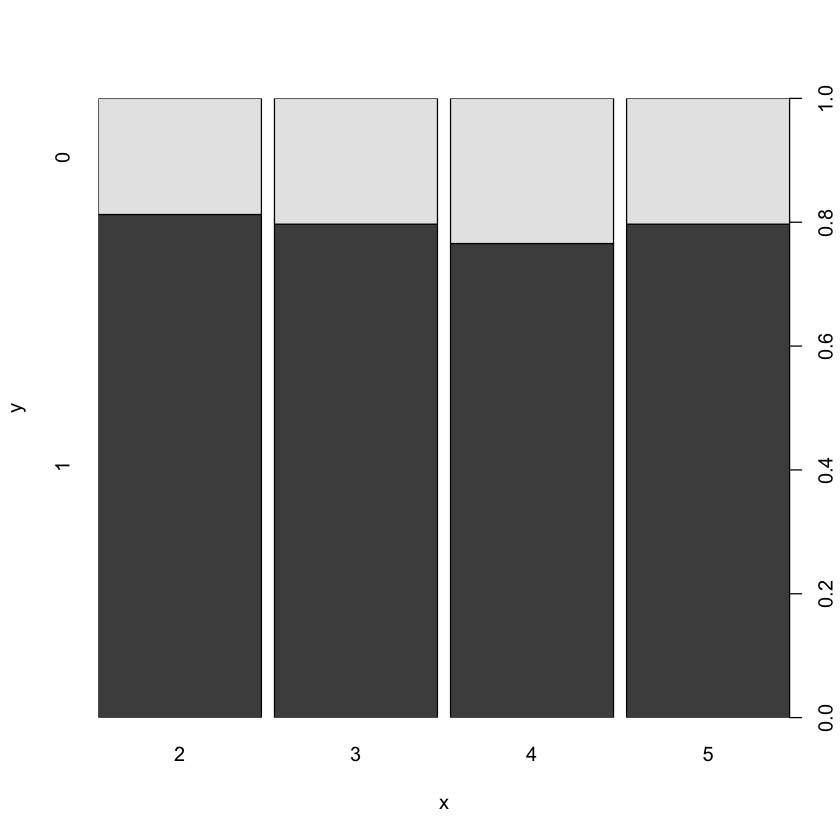

In [20]:
plot(ELP$Visit, ELP$Final_Binary)

## Initial Conclusions
- Ants choose the Left side of the Y-maze more often than what would be predicted by chance 
- Ants are significantly less likely to choose the Right side of the Y-maze [0.07-0.67]
- Octopamine has no effect on Y-maze side choice compared to the control treatment

## Brain lateralisation VS Visual Cues
Is the side bias a repercution of natural brain lateralisation or the ants prefer to go towards the experimentor or the wall? **Laura's setup had the wall on the Right whilst Stefanie had the wall on the Left!**


Laura Neubauer   Stefanie Kau 
           108            148 

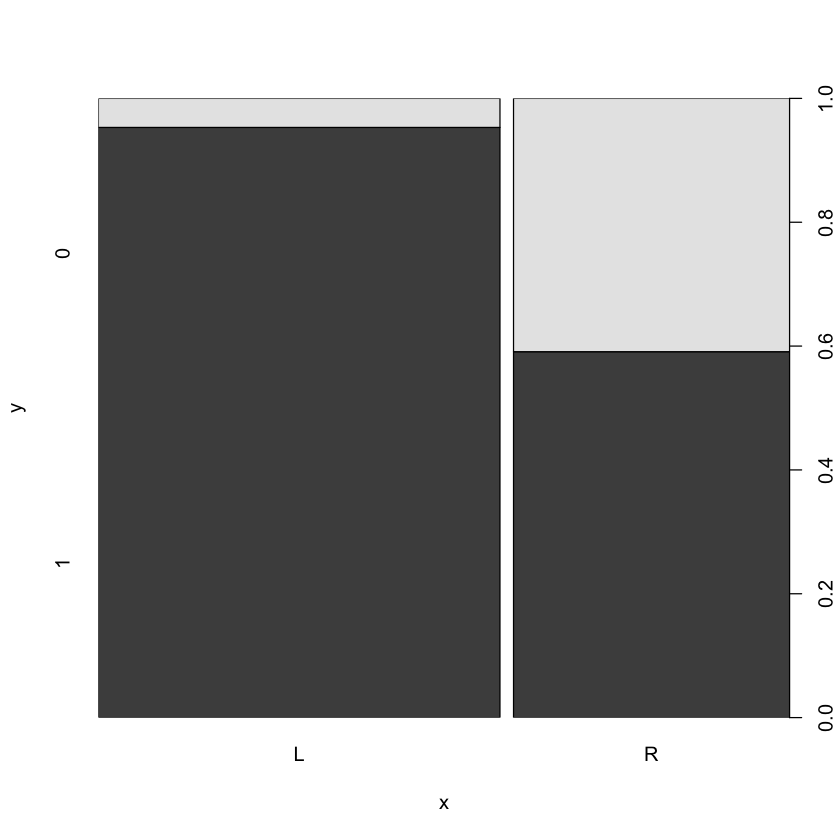

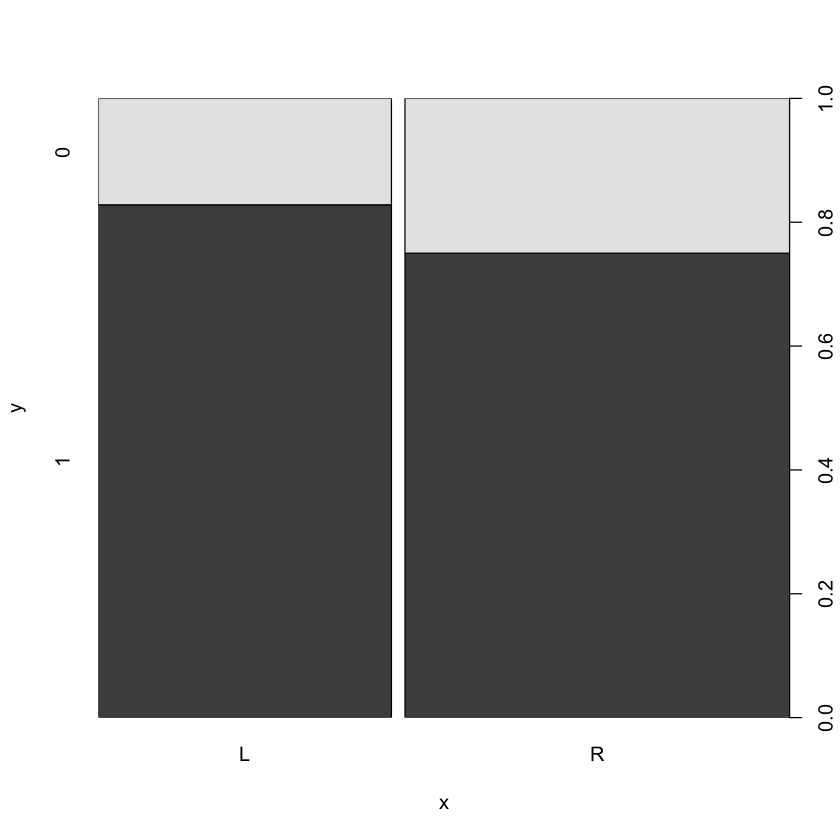

In [21]:
table(ELP$Experimentor) # Sample sizes
plot(subset(ELP, ELP$Experimentor == "Laura Neubauer")$Reward_Side, subset(ELP, ELP$Experimentor == "Laura Neubauer")$Final_Binary)
plot(subset(ELP, ELP$Experimentor == "Stefanie Kau")$Reward_Side, subset(ELP, ELP$Experimentor == "Stefanie Kau")$Final_Binary)

**There is a strong side bias towards Left on Laura's data but a very subtle one on Stefanie's data. This could be because ants have brain lateralisation, leading to a preference towards Left, whilst also tending to move away from the wall towards the experimentor. In this case, Stefanie's data, where the experimentor was on the Right, which ants prefer moving towards, balances out with their natural preference of turning Left leading to a smaller bias. In Laura's data however, since both the ant's natural preference and the experimentor were on the Left this leads to a very significant Left bias.**

## Looking exclusively at Stefanie's data to decrease the side bias

In [22]:
ELP = subset(ELP, ELP$Experimentor == "Stefanie Kau")

## Re-run the models above without Experimentor as a random factor

In [23]:
null_mod = glmer(Final_Binary ~ 1 + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
visit_mod = glmer(Final_Binary ~ Visit + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
solution_mod = glmer(Final_Binary ~ Solution + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
side_mod = glmer(Final_Binary ~ Reward_Side + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
tsm_mod = glmer(Final_Binary ~ TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
solution_time_mod = glmer(Final_Binary ~ Solution + TSM_Bin + Visit + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))
max_mod = glmer(Final_Binary ~ Solution + Visit + TSM_Bin + Reward_Side + Solution:TSM_Bin + (1|Collection_Date) + (Starvation_Period|Colony_ID) + (1|Ant_ID), data = ELP, family = "binomial", glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 1000000000)))

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



In [24]:
cand_models = list("null_mod" = null_mod, 
                   "visit_mod" = visit_mod,
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod,
                   "solution_time_mod" = solution_time_mod,
                   "max_mod" = max_mod)

aictab(cand_models)
confset(cand.set = cand_models) # Remove models that explain the last 0.05 Cum.Wt

,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_mod,6,159.5802,0.000000,1.00000000,0.456784805,-73.49220,0.4567848
4,side_mod,7,161.2759,1.695764,0.42832118,0.195650608,-73.23796,0.6524354
5,tsm_mod,7,161.7618,2.181609,0.33594604,0.153455047,-73.48088,0.8058905
3,solution_mod,7,161.7711,2.190909,0.33438764,0.152743193,-73.48553,0.9586337
2,visit_mod,9,165.4991,5.918993,0.05184502,0.023682020,-73.09740,0.9823157
6,solution_time_mod,12,166.6920,7.111804,0.02855561,0.013043769,-70.19042,0.9953594
7,max_mod,13,168.7589,9.178755,0.01015918,0.004640558,-70.02124,1.0000000


,Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Cum.Wt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,null_mod,6,159.5802,0.000000,1.0000000,0.4567848,-73.49220,0.4567848
4,side_mod,7,161.2759,1.695764,0.4283212,0.1956506,-73.23796,0.6524354
5,tsm_mod,7,161.7618,2.181609,0.3359460,0.1534550,-73.48088,0.8058905
3,solution_mod,7,161.7711,2.190909,0.3343876,0.1527432,-73.48553,0.9586337


There is no longer a clearly better model!

In [25]:
top_models = list("null_mod" = null_mod, 
                   "solution_mod" = solution_mod,
                   "side_mod" = side_mod,
                   "tsm_mod" = tsm_mod)

modavgShrink(top_models, parm = "(Intercept)")
modavgShrink(top_models, parm = "SolutionOctopamine")
modavgShrink(top_models, parm = "Reward_SideR")
modavgShrink(top_models, parm = "TSM_Bin31-60")

Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,6,159.5802,0.000000,1.0000000,0.4764957,-73.49220,1.705840,0.3688826
solution_mod,7,161.7711,2.190909,0.3343876,0.1593343,-73.48553,1.739829,0.4752198
side_mod,7,161.2759,1.695764,0.4283212,0.2040932,-73.23796,1.949470,0.5293940
tsm_mod,7,161.7618,2.181609,0.3359460,0.1600768,-73.48088,1.754672,0.4960953


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,6,159.5802,0.000000,1.0000000,0.4764957,-73.49220,0.00000000,0.0000000
solution_mod,7,161.7711,2.190909,0.3343876,0.1593343,-73.48553,-0.06962804,0.6020347
side_mod,7,161.2759,1.695764,0.4283212,0.2040932,-73.23796,0.00000000,0.0000000
tsm_mod,7,161.7618,2.181609,0.3359460,0.1600768,-73.48088,0.00000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,6,159.5802,0.000000,1.0000000,0.4764957,-73.49220,0.0000000,0.0000000
solution_mod,7,161.7711,2.190909,0.3343876,0.1593343,-73.48553,0.0000000,0.0000000
side_mod,7,161.2759,1.695764,0.4283212,0.2040932,-73.23796,-0.4567996,0.6397413
tsm_mod,7,161.7618,2.181609,0.3359460,0.1600768,-73.48088,0.0000000,0.0000000


Modnames,K,AICc,Delta_AICc,ModelLik,AICcWt,LL,Beta_est,SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
null_mod,6,159.5802,0.000000,1.0000000,0.4764957,-73.49220,0.00000000,0.0000000
solution_mod,7,161.7711,2.190909,0.3343876,0.1593343,-73.48553,0.00000000,0.0000000
side_mod,7,161.2759,1.695764,0.4283212,0.2040932,-73.23796,0.00000000,0.0000000
tsm_mod,7,161.7618,2.181609,0.3359460,0.1600768,-73.48088,-0.08875722,0.5895665


## Odds
**If the odds is 1 there is no effect, therefore if the CI's cross 1 that is not a significant parameter**

**Intercept** = 5.9 [2.4, 14.3] -> **Ants do not choose an arm of the Y-maze randomly!**

**Solution** = 0.99 [0.6, 1.6] -> There is no effect of Solution!

**Side** = 0.9 [0.5, 1.8] -> There is no effect of Side!

**TSM** = 0.9 [0.6, 1.6] -> There is no effect of Time Since Marking!

## Conclusions
- Starting from Visit 2 80% of the ants tested choose correclty and this is retained over visits. This leads to no effect of Visit.
- There is no effect of Time Since Marking on final choice.
- There is no efect of Octopamine on final choice.
- If we look at the data from both experimentors there is a significant side bias towards the Left. However, if we look exclusively at Stefanie's data there is no effect of Side.